# AP Project

MohammadErfan Gooneh / 125310936

mohammad.erfan.gooneh@gmail.com

In [62]:
!pip install Pillow requests numpy

In [52]:
#importing requirments
from io import BytesIO
from PIL import Image
from IPython.display import display
import requests as r
import numpy as np

In [12]:
# To don't create digits.json again
INTIALIZING = False

In [13]:
url = "https://ap.utprojects.ir/acc/login"

In [14]:
#creating session
session = r.Session()
session.get(url)
data = {
    "username":"125310936", 
    "password": "X", 
    "captcha": "X"
}
res = session.post(url, data=data)
res.text

'{"message": "Invalid CAPTCHA!", "status": 2}'

In [15]:
img_url = "https://ap.utprojects.ir/acc/captcha"
res = session.get(img_url)

(200, 50)


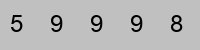

In [16]:
sample = Image.open(BytesIO(res.content))
print(sample.size)
sample.convert('L')

In [17]:
def split_image(img : Image) -> list:
    return [img.crop((i*40, 0, i*40 + 40, 50)) for i in range(5)]

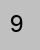

In [18]:
x = split_image(sample)
x[1]

Assuming digits are randomly distributed. at each new captcha we will get $5$ digits between [0,9] inclusive. 

we define $S(n) := $ expected digits to reveal to make sure we have all $n$ different digits $(n \le 10)$

now we know that $S(n) = \frac{n \times (S(n-1) + 1)}{10} + \frac{(10-n)(S(n)+1)}{10}$

so $S(n) = \frac{10}{n} \times \frac{n \times (S(n-1) + 1) + (10-n)}{10}$

$S(1) = \frac{1}{10} + \frac{9}{10} \times (S(1) + 1) = 10$ 

we want $S(10)$:



In [8]:
s = [10]
for i in range(2, 11):
    s.append(s[i-2] + 1 + (10-i)/i)
s

[10,
 15.0,
 18.333333333333332,
 20.833333333333332,
 22.833333333333332,
 24.5,
 25.928571428571427,
 27.178571428571427,
 28.289682539682538,
 29.289682539682538]

as we are getting 5 digits at each GET request, it is expected to get all digits after $\approx \frac{30}{5} = 6$ times but we will request 10 times to make sure :)

In [29]:
def img_to_tuple(img: Image) -> tuple:
    nd = np.asarray(img)
    return tuple(map(tuple, nd))

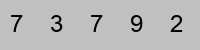

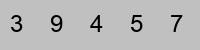

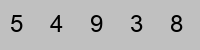

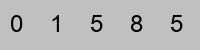

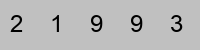

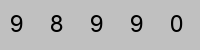

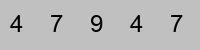

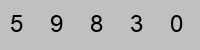

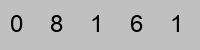

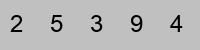

In [23]:
digits_count = dict()
naming_list = []
for _ in range(10):
    session.get(url)
    img = Image.open(BytesIO(session.get(img_url).content))
    img = img.convert('L')
    display(img)
    splitted = split_image(img)
    tuple_splitted = [img_to_tuple(i) for i in split_image]
    naming_list += tuple_splitted
    for t in tuple_splitted:
        digits_count[t] = digits_count.get(t, 0) + 1

In [24]:
digits_count.values()

dict_values([5, 6, 11, 3, 5, 6, 5, 4, 4, 1])

In [4]:
digits = {}
if INTIALIZING:
    digits[naming_list[0]] = 7
    digits[naming_list[1]] = 3
    digits[naming_list[3]] = 9
    digits[naming_list[4]] = 2
    digits[naming_list[7]] = 4
    digits[naming_list[8]] = 5
    digits[naming_list[14]] = 8
    digits[naming_list[15]] = 0
    digits[naming_list[16] ] = 1
    digits[naming_list[43]] = 6


### Saving tags

this results are not consistent so i will save digits dictionary as json for further usages. 

In [5]:
# Serializing pixels(tuples) as string
if INTIALIZING:
    ser_digits = {str(key): value for key, value in digits.items()}
    with open("digits.json", "w") as f:
        import json
        json.dump(ser_digits, f)

### Solving Captcha

now we are able to solve captcha

In [6]:
# Loading digits and deserialization
with open("digits.json", "r") as f:
    import json
    global ser_digits
    ser_digits = json.load(f)

In [9]:
digits = {eval(key): value for key, value in ser_digits.items()}
digits

{((192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192),
  (192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192),
  (192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192,
   192),
  (192,
   192,
   192,
   192,
   19

In [27]:
def captcha_solver(img: Image) -> str:
    img = img.convert('L')
    splitted = split_image(img)
    tuple_splitted = [img_to_tuple(i) for i in splitted]
    ans = [str(digits[s]) for s in tuple_splitted]
    return ''.join(ans)

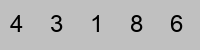

43186


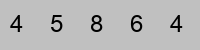

45864


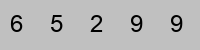

65299


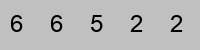

66522


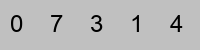

07314


In [33]:
## testing captcha solver 

for _ in range(5):
    session.get(url)
    img = Image.open(BytesIO(session.get(img_url).content)).convert('L')
    display(img)
    print(captcha_solver(img))

### Binary search on password

In [56]:
def send_request(password:str) -> int:
    captcha_img = Image.open(BytesIO(session.get(img_url).content))
    captcha = captcha_solver(captcha_img)
    data = {
        "username": "125310936", 
        "password": password, 
        "captcha": captcha
    }
    res = session.post(url, data=data)
    import json
    res_data = json.loads(res.text)
    valid_status = [-1, 0, 1]
    if(res_data['status'] not in valid_status):
        print(res_data)
    return res_data['status']

In [57]:
send_request("123")

1

In [61]:
l, r = 0, 999_999_999_999 + 1
step = 0
import requests
session = requests.Session()
session.get(url)
while l < r:
    step += 1
    m = (l+r)//2 
    status = send_request(str(m))
    messages = {
        1: "It is lower than expected", 
        -1: "It is greater than expected",
        0: "Correct!"
    }
    message = messages.get(status, " ERROR " + str(status))
    print(f"Step # {step} : Password:{m} , Status:{message}")
    if status == 1:
        l = m
    elif status == -1:
        r = m
    else:
        break 
    

Step # 1 : Password:500000000000 , Status:It is lower than expected
Step # 2 : Password:750000000000 , Status:It is greater than expected
Step # 3 : Password:625000000000 , Status:It is lower than expected
Step # 4 : Password:687500000000 , Status:It is greater than expected
Step # 5 : Password:656250000000 , Status:It is lower than expected
Step # 6 : Password:671875000000 , Status:It is greater than expected
Step # 7 : Password:664062500000 , Status:It is greater than expected
Step # 8 : Password:660156250000 , Status:It is lower than expected
Step # 9 : Password:662109375000 , Status:It is lower than expected
Step # 10 : Password:663085937500 , Status:It is lower than expected
Step # 11 : Password:663574218750 , Status:It is greater than expected
Step # 12 : Password:663330078125 , Status:It is greater than expected
Step # 13 : Password:663208007812 , Status:It is lower than expected
Step # 14 : Password:663269042968 , Status:It is greater than expected
Step # 15 : Password:66323852

### So my password is : 663235350941